## Exploring PRISM Climate Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def read_prism_hdr(hdr_path):
    """Read an ESRI BIL HDR file"""
    with open(hdr_path, 'r') as input_f:
        header_list = input_f.readlines()
    output = dict(item.strip().split() for item in header_list)
    return output

def read_prism_bil(bil_path):
    """Read an array from ESRI BIL raster file"""
    hdr_dict = read_prism_hdr(bil_path.replace('.bil', '.hdr'))
    # For now, only use NROWS, NCOLS, and NODATA
    # Eventually use NBANDS, BYTEORDER, LAYOUT, PIXELTYPE, NBITS
    prism_array = np.fromfile(bil_path, dtype=np.float32)
    prism_array = prism_array.reshape(
        int(hdr_dict['NROWS']), int(hdr_dict['NCOLS']))
    prism_array[prism_array == float(hdr_dict['NODATA'])] = np.nan
    return prism_array, hdr_dict

In [3]:
def get_prism_coords(coords, header):
    result = coords.copy()
    result[0] -= (float(header["ULXMAP"]) - float(header["XDIM"])/2.0)
    result[0] /= float(header["XDIM"])
    result[1] -= (float(header["ULYMAP"]) + float(header["YDIM"])/2.0)
    result[1] /= -float(header["YDIM"])
    return result

In [4]:
def get_prism_data(attribute):
    years = range(1895, 2020)
    months = range(1, 13)
    arrays = []
    headers = {}
    for yr in years:
        annual_arrays = []
        for month in months:
            ver = 2 if (yr < 1981 and attribute == "ppt") else 3
            prism_path = 'prism_climate_data/{}/{}/PRISM_{}_stable_4kmM{}_{}{:02d}_bil.bil'.format(attribute,yr,attribute,ver,yr,month)
            prism_array, prism_header = read_prism_bil(prism_path)
            headers[(yr, month)] = prism_header
            annual_arrays.append(prism_array)
        arrays.append(np.stack(annual_arrays, axis=0))
    
    # 2020 is partial, so we need to append some extra null arrays
    annual_arrays = []
    for month in months:
        if month < 5:
            prism_path = 'prism_climate_data/{}/{}/PRISM_{}_stable_4kmM3_{}{:02d}_bil.bil'.format(attribute,yr,attribute,yr,month)
            prism_array, prism_header = read_prism_bil(prism_path)
            headers[(yr, month)] = prism_header
            annual_arrays.append(prism_array)
        else:
            arr = np.zeros((621,1405))
            arr[:,:] = np.nan
            annual_arrays.append(arr)
    arrays.append(np.stack(annual_arrays, axis=0))
    
    prism_array = np.stack(arrays, axis=0)
    
    # Check to make sure the headers are the same for each year
    for k, h in headers.items():
        for hk, hv in prism_header.items():
            assert h[hk] == hv, "{} differs from last header".format(k)
    
    return prism_array, prism_header

In [5]:
prism_array, prism_header = get_prism_data("ppt")
print(prism_header)
print(prism_array.shape)

{'BYTEORDER': 'I', 'LAYOUT': 'BIL', 'NROWS': '621', 'NCOLS': '1405', 'NBANDS': '1', 'NBITS': '32', 'BANDROWBYTES': '5620', 'TOTALROWBYTES': '5620', 'PIXELTYPE': 'FLOAT', 'ULXMAP': '-125', 'ULYMAP': '49.9166666666664', 'XDIM': '0.0416666666667', 'YDIM': '0.0416666666667', 'NODATA': '-9999'}
(126, 12, 621, 1405)


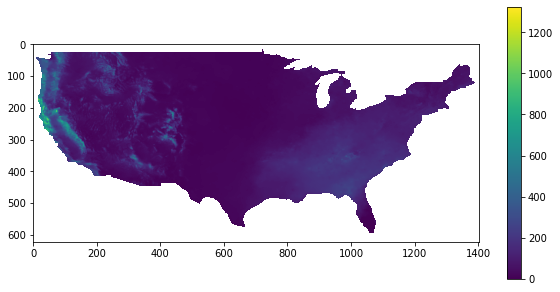

In [6]:
plt.imshow(prism_array[0,0]) # 0th year is 1895, 0th month is January
plt.gcf().set_size_inches(10, 5)
plt.colorbar()
plt.show()

[[326.499992 301.86008  287.700008 444.74     437.5472   470.14664 ]
 [577.5      553.36656  537.3      227.7      209.4744   209.1     ]]


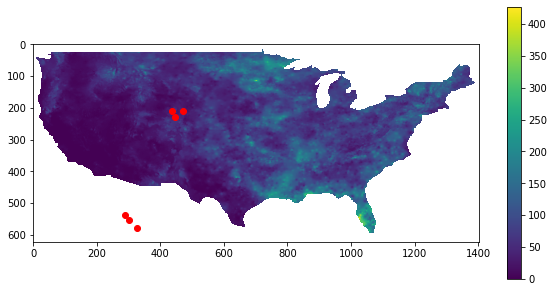

In [7]:
sample_lon_lat = np.array(
    [[-111.416667, -112.44333, -113.033333, -106.49, -106.7897, -105.43139],
     [25.875, 26.88056, 27.55, 40.45, 41.2094, 41.225]]
)

transformed_coords = get_prism_coords(sample_lon_lat, prism_header)
print(transformed_coords)

plt.imshow(prism_array[100,6])
plt.colorbar()
plt.scatter(transformed_coords[0], transformed_coords[1], color="red")
plt.gcf().set_size_inches(10, 5)
plt.show()

In [8]:
import pandas as pd
cch2 = pd.read_csv("continental_US_CCH2_2/full_dataset.csv",
                   usecols=["scientificName", "year", "month", "decimalLongitude", "decimalLatitude", "flowering"],
                   dtype={"scientificName":str, "year":int, "month":int, "decimalLongitude":float, "decimalLatitude":float, "flowering":float})

In [9]:
def lookup_climate_data(records, # Pandas Dataframe
                        prism_array, # Numpy Ndarray of shape (years, months, lat_bins, lon_bins)
                        prism_header, # Header for prism data
                        col_name, # Name of data being computed
                        month_override=None, # Override month indexing to take a single value
                        normalized=True): # If true, subtract the mean over the observed period (1895-2020)
    
    # Drop rows with any null indexing variables
    initial_len = len(records)
    records = records.dropna(subset=["year", "decimalLongitude", "decimalLatitude"])
    
    # Drop rows that are out of bounds on any axis
    minLon = float(prism_header["ULXMAP"]) - float(prism_header["XDIM"])/2.0
    maxLon = minLon + prism_array.shape[3] * float(prism_header["XDIM"])
    maxLat = float(prism_header["ULYMAP"]) + float(prism_header["YDIM"])/2.0
    minLat = maxLat - prism_array.shape[2] * float(prism_header["YDIM"])
    records = records.loc[  (records["year"] >= 1895)
                          & (records["year"] <= 2020)
                          & (records["decimalLatitude"] > minLat)
                          & (records["decimalLatitude"] < maxLat)
                          & (records["decimalLongitude"] > minLon)
                          & (records["decimalLongitude"] < maxLon)]
    
    # Handle month separately as it is sometimes uneccesary
    if month_override is None:
        records = records.dropna(subset=["month"])
        records = records.loc[(records["month"] >= 1) & (records["month"] <= 12)]
    
    final_len = len(records)
    print("{}/{} records do not have good year/month/lat/lon".format(initial_len - final_len,
                                                                     initial_len))
    coords = get_prism_coords(records[["decimalLongitude", "decimalLatitude"]].values.T,
                              prism_header).astype(int)
    if month_override is None:
        # Index by the month in which each sample was collected
        month_index = records["month"].values
    else:
        # Index by a specified month
        month_index = month_override
    
    vals = prism_array[records["year"].values-1895, # Year indexed from 1895
                       month_index-1, # Month indexed from January
                       coords[1], # Transformed latitude
                       coords[0]] # Transformed longitude
    
    if normalized:
        # Compute the mean over all years and subtract from vals
        vals -= np.nanmean(prism_array,axis=0)[month_index-1,coords[1],coords[0]]
    
    return pd.Series(vals, index=records.index, name=col_name)

In [10]:
new_col = lookup_climate_data(cch2, prism_array, prism_header, "ppt_at_collection")
cch2[new_col.name] = np.nan
cch2.loc[new_col.index, new_col.name] = new_col
cch2.head()

864/1510985 records do not have good year/month/lat/lon


<ipython-input-9-5f39209b89a4>:48: RuntimeWarning: Mean of empty slice
  vals -= np.nanmean(prism_array,axis=0)[month_index-1,coords[1],coords[0]]


,scientificName,year,month,decimalLatitude,decimalLongitude,flowering,ppt_at_collection
0,Cyrtocarpa edulis,2007,9,24.05743,-111.97786,1.0,NaN
1,Fagonia villosa,2007,9,24.05743,-110.97785,1.0,NaN
2,Atriplex barclayana,1996,11,24.06667,-110.98333,1.0,NaN
3,Sesuvium verrucosum,1959,5,24.07118,-111.00394,1.0,NaN
4,Perityle crassifolia,1959,5,24.07118,-111.00394,1.0,NaN


<AxesSubplot:ylabel='Frequency'>

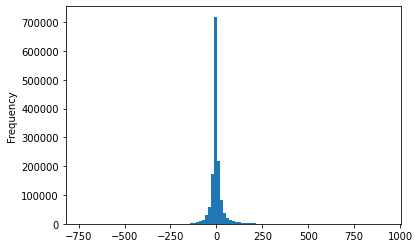

In [11]:
cch2["ppt_at_collection"].plot.hist(bins=101)

In [12]:
cch2["ppt_at_collection"].notna().value_counts() / len(cch2)

True     0.937694
False    0.062306
Name: ppt_at_collection, dtype: float64

In [13]:
len(cch2)

1510985